In [3]:
from ising_compiler.ising_nx import IsingGraph
from ising_compiler.gates_nx import IsingCircuit
from ising_compiler.alu_nx import IsingALU
from pprint import pprint
from tqdm import tqdm

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.image as mpimg
from matplotlib.gridspec import GridSpec

from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import product

## XOR gate

In [3]:
circuit = IsingCircuit(copy_mode = "primed")
a = circuit.INPUT("A")
b = circuit.INPUT("B")
c = circuit.XOR(a, b, out="C", anc="X")
circuit.OUTPUT(c)

output_dict = circuit.evaluate_circuit(runs = 100, epochs_per_run = 1000, show_progress=True, anneal_temperature_range = [.5, 1e-3])

pprint(output_dict)

100%|██████████| 4/4 [00:08<00:00,  2.23s/it]

{"{'A': 0, 'B': 0}": {'C': 0.0},
 "{'A': 0, 'B': 1}": {'C': 1.0},
 "{'A': 1, 'B': 0}": {'C': 1.0},
 "{'A': 1, 'B': 1}": {'C': 0.0}}


100%|██████████| 1000/1000 [00:00<00:00, 23495.13it/s]


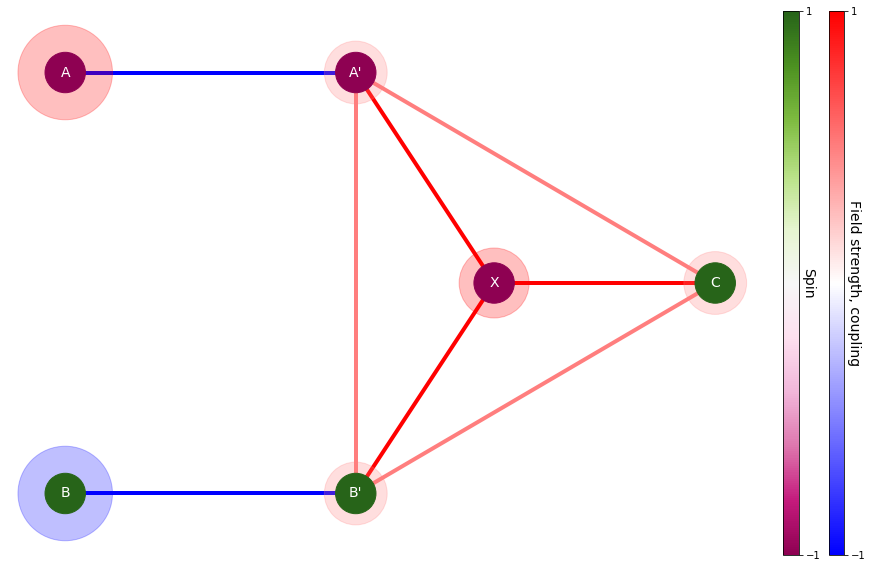

In [4]:
out = circuit.evaluate_input({"A":0, "B":1}, mode='binary', epochs = 1000, show_progress=True, anneal_temperature_range = [.5, 1e-3])
pos = {
    "A": [.3, 1],
    "B": [.3, 0],
    "A'": [1, 1],
    "B'": [1, 0],
    "C": [1 + np.sqrt(3)/2, 1/2],
    "X": [1 + 1/3, 1/2]
}
IsingGraph.visualize_graph(circuit.graph, pos=pos)
plt.savefig("assets/XOR.pdf", dpi=300, bbox_inches="tight")

# Full adder

In [7]:
circuit = IsingCircuit(copy_mode="primed")
A = circuit.INPUT("A")
B = circuit.INPUT("B")
Cin = circuit.INPUT("Cin")

aXORb = circuit.XOR(A, B, out="O1", anc="X1")
S = circuit.XOR(aXORb, Cin, out = "S", anc="X2")
aANDb = circuit.AND(A, B, out="O2")
aXORbANDc = circuit.AND(aXORb, Cin, out="O3")
Cout = circuit.OR(aANDb, aXORbANDc, out = "Cout")

circuit.OUTPUT(S)
circuit.OUTPUT(Cout)

# all_input_combos = [[int(x) for x in ('{:03b}').format(n)] for n in range(2 ** 3)]

# for inputs in tqdm(all_input_combos, desc = "FULLADDR"):
# a, b, cin = inputs

expectations = circuit.evaluate_input({"A": 1, "B": 1, "Cin": 0},
                                      mode='binary',
                                      epochs = 20000,
                                      anneal_temperature_range = [1, 1e-4],
                                      show_progress = True)
s_exp = expectations[S]
cout_exp = expectations[Cout]

100%|██████████| 20000/20000 [00:00<00:00, 32958.44it/s]


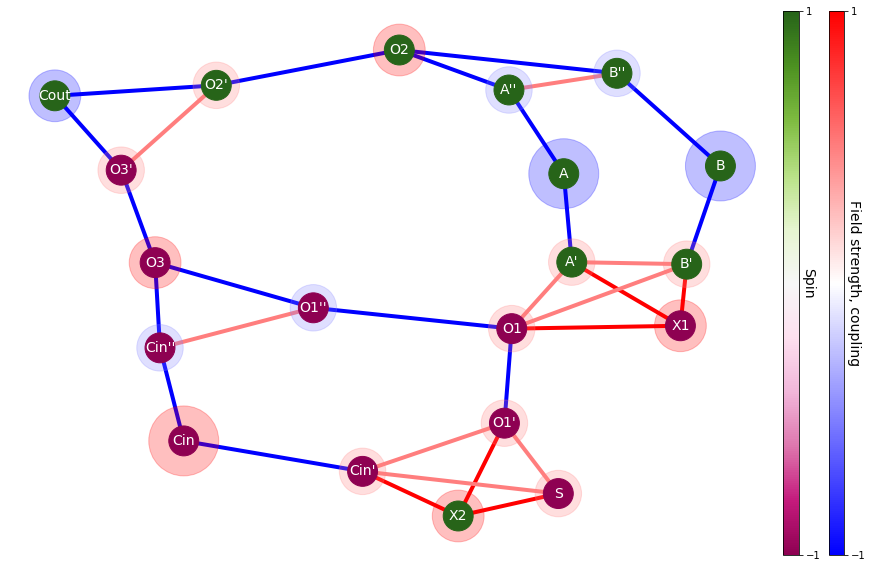

In [9]:
IsingGraph.visualize_graph(circuit.graph)
plt.savefig("assets/full_adder_spins.png", dpi=300)

In [95]:
pos = {
    "A": [0, 7],
    "B": [0, 5],
    "Cin": [0, 4],
    "A'": [3, 7],
    "B'": [3, 5],
    "X1": [4, 6],
    "O1": [5, 6],
    "O1'": [7, 6],
    "Cin'": [7, 4],
    "X2": [8, 5],
    "S": [9, 5],
    "Cin''": [4, 3],
    "O3": [5, 2],
    "O1''": [5, 3],
    "A''": [3, 2],
    "B''": [3, 1],
    "O2": [4, 1],
    "O2'": [7, 1],
    "O3'": [7, 2],
    "Cout": [8, 1]
}

/Users/ben/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


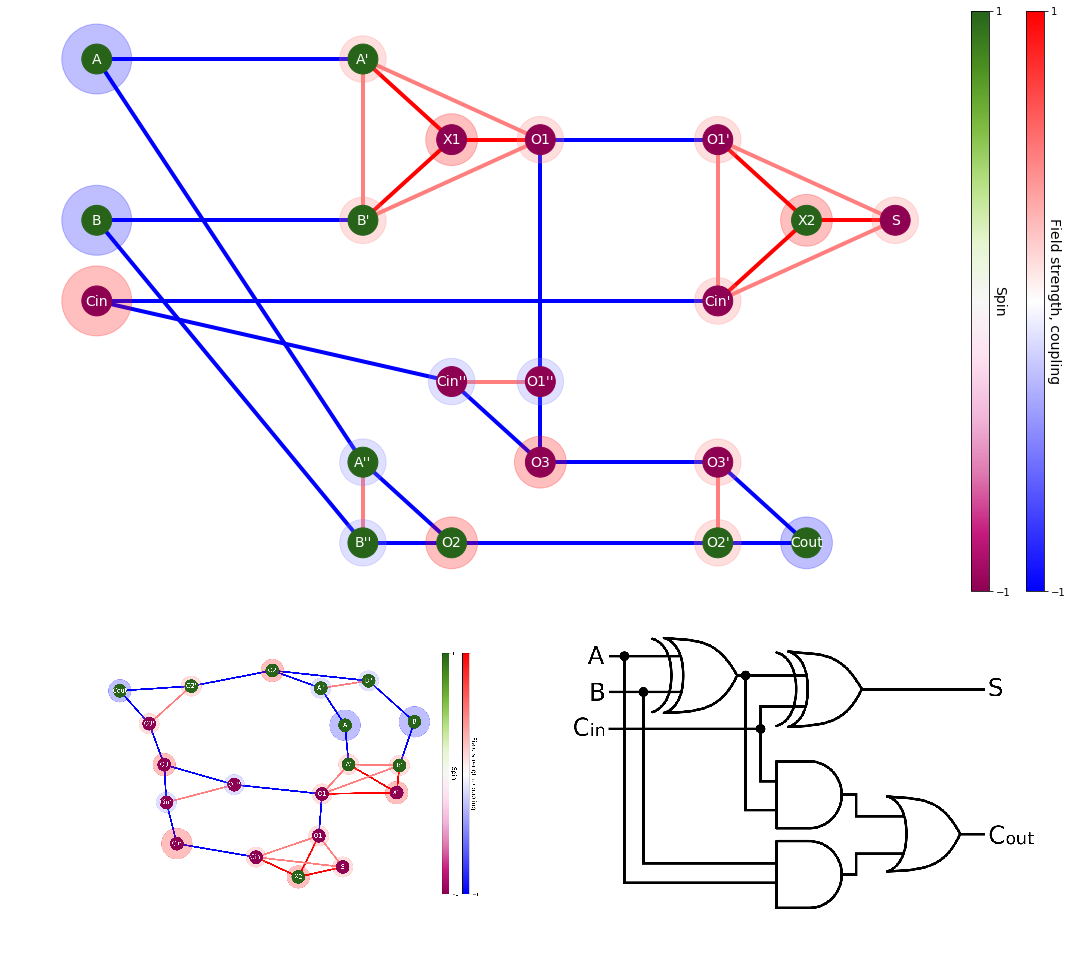

In [11]:
im1 = mpimg.imread('assets/full_adder.png')
im2 = mpimg.imread('assets/full_adder_spins.png')

fig = plt.figure(figsize=(15,15), tight_layout=True)
gs = GridSpec(2, 2)

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
IsingGraph.visualize_graph(circuit.graph, pos=pos, fig=fig, ax=ax1)
ax2.imshow(im2)
ax2.axis("off")
ax3.imshow(im1)
ax3.axis("off")

plt.savefig("assets/full_adder_figure.png", dpi=300, bbox_inches="tight")

# Ripple carry adder

In [40]:
circuit = IsingALU()
num_bits = 8

S_bits, Cout = circuit.RIPPLE_CARRY_ADDER(num_bits)

num1, num2 = 100, 99
digs1 = [int(x) for x in ('{:0' + str(num_bits) + 'b}').format(num1)]
digs2 = [int(x) for x in ('{:0' + str(num_bits) + 'b}').format(num2)]

input_dict = {}
for i, (a, b) in enumerate(zip(reversed(digs1), reversed(digs2))):
    input_dict["A" + str(i)] = a
    input_dict["B" + str(i)] = b

digs_sum = [int(x) for x in ('{:0' + str(num_bits+1) + 'b}').format(num1+num2)]
desired_output = {"C"+str(num_bits): digs_sum[0]}
for i, dig in enumerate(reversed(digs_sum[1:])):
    desired_output["S"+str(i)] = dig

print("Testing {} + {} = {} with inputs:".format(num1, num2, num1 + num2))
pprint(input_dict)

print("Desired output:")
pprint(desired_output)

epochs_per_run = min(100000 * 2 ** num_bits, int(1e7))
# output = circuit.evaluate_outcomes(input_dict, runs=20, epochs_per_run = epochs_per_run, anneal_temperature_range = [1, 1e-4], show_progress = True)
output = circuit.evaluate_input(input_dict, epochs = epochs_per_run, anneal_temperature_range = [1, 1e-4], show_progress = True, video=True)

print("Measured output:")
pprint(output)

  0%|          | 0/10000000 [00:00<?, ?it/s]

Testing 100 + 99 = 199 with inputs:
{'A0': 0,
 'A1': 0,
 'A2': 1,
 'A3': 0,
 'A4': 0,
 'A5': 1,
 'A6': 1,
 'A7': 0,
 'B0': 1,
 'B1': 1,
 'B2': 0,
 'B3': 0,
 'B4': 0,
 'B5': 1,
 'B6': 1,
 'B7': 0}
Desired output:
{'C8': 0,
 'S0': 1,
 'S1': 1,
 'S2': 1,
 'S3': 0,
 'S4': 0,
 'S5': 0,
 'S6': 1,
 'S7': 1}


100%|██████████| 10000000/10000000 [08:30<00:00, 19592.90it/s]

Measured output:
{'C8': 0,
 'S0': 1,
 'S1': 1,
 'S2': 1,
 'S3': 0,
 'S4': 0,
 'S5': 0,
 'S6': 1,
 'S7': 1}


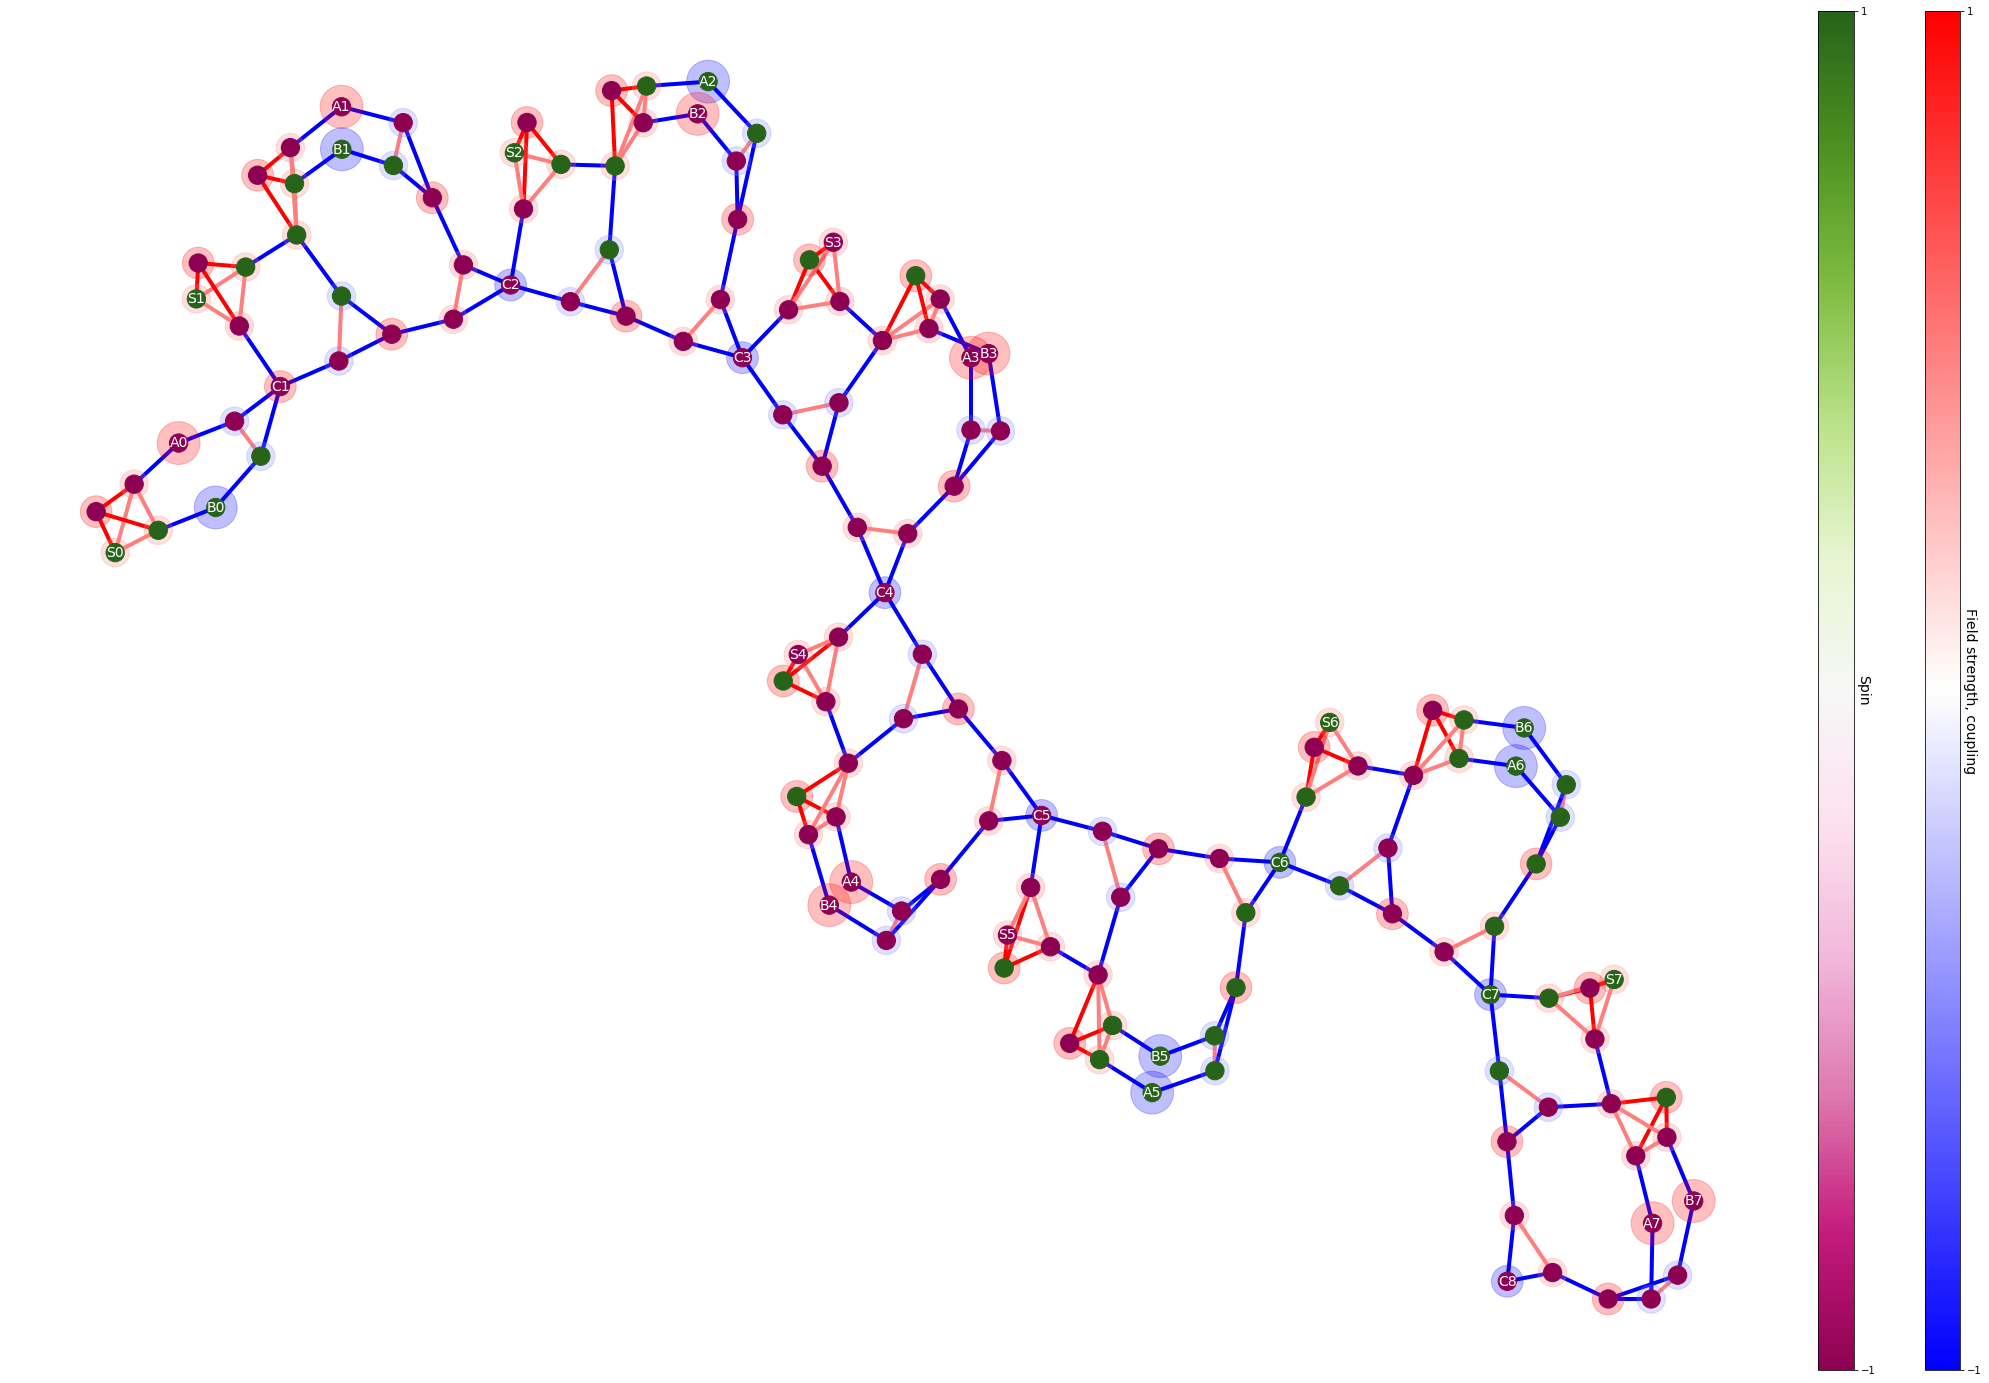

In [68]:
fig = plt.figure(figsize = (35, 25))
ax = fig.add_subplot(1, 1, 1)
IsingGraph.visualize_graph(circuit.graph, fig=fig, ax=ax)
plt.savefig("assets/ripple_carry_adder2.pdf", dpi=300, bbox_inches="tight")

## Planarizing gates

In [92]:
c1 = IsingCircuit(copy_mode = "primed")
a = c1.INPUT("A")
b = c1.INPUT("B")
c = c1.NAND(a, b, out="C")
c1.OUTPUT(c)

out = c1.evaluate_input({"A":0, "B":1}, mode='binary', epochs = 1000, show_progress=False, anneal_temperature_range = [.5, 1e-3])
pos1 = {
    "A": [.3, 1],
    "B": [.3, 0],
    "A'": [1, 1],
    "B'": [1, 0],
    "C": [1 + np.sqrt(3)/2, 1/2]
}
# IsingGraph.visualize_graph(c1.graph, pos=pos1)

In [93]:
def NAND_planar(circuit, in1, in2, out = None):
    s1, s2 = circuit.copy_inputs(in1, in2)
    s2prime = circuit.copy_inputs(s2)[0]
    s3 = circuit.add_spin(out)
    circuit.set_field(s1, -1 / 2)
    circuit.set_field(s2, -1 / 2)
    circuit.set_field(s3, -1)
    circuit.set_coupling(s1, s2, 1 / 2)
    circuit.set_coupling(s1, s3, 1)
    circuit.set_coupling(s2prime, s3, 1)
    return s3

c2 = IsingCircuit(copy_mode = "primed")
a = c2.INPUT("A")
b = c2.INPUT("B")
c = NAND_planar(c2, a, b, out="C")
c2.OUTPUT(c)

out_dict = c2.evaluate_circuit(runs=100, anneal_temperature_range = [.5, 1e-3], show_progress=False)

pprint(out_dict)

out = c2.evaluate_input({"A":0, "B":1}, mode='binary', epochs = 1000, show_progress=False, anneal_temperature_range = [.5, 1e-3])

pos2 = {
    "A": [.3, 1],
    "B": [.3, 0],
    "A'": [1, 1],
    "B'": [1, 0],
    "B''": [2, 0],
    "C": [2, 1]
}
# IsingGraph.visualize_graph(c2.graph, pos=pos2)

{"{'A': 0, 'B': 0}": {'C': 1.0},
 "{'A': 0, 'B': 1}": {'C': 1.0},
 "{'A': 1, 'B': 0}": {'C': 1.0},
 "{'A': 1, 'B': 1}": {'C': 0.0}}


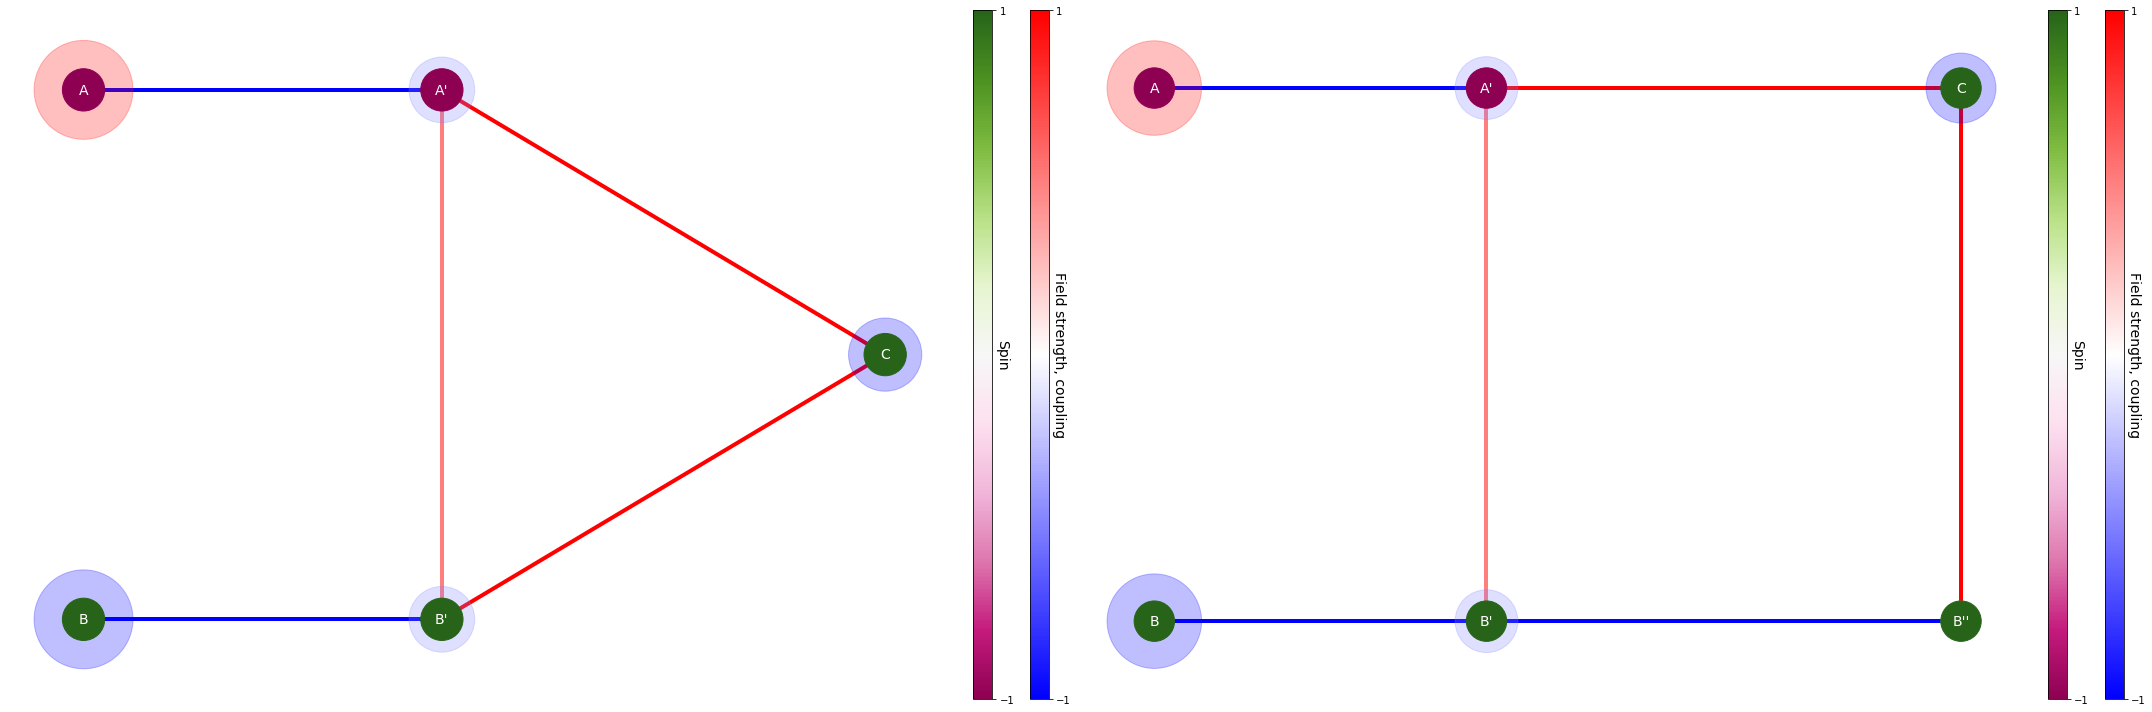

In [91]:
fig = plt.figure(figsize=(30,10), tight_layout=True)
gs = GridSpec(1, 2)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

IsingGraph.visualize_graph(c1.graph, pos=pos1, fig=fig, ax=ax1)
IsingGraph.visualize_graph(c2.graph, pos=pos2, fig=fig, ax=ax2)

plt.savefig("assets/planar_nand.png", dpi=300, bbox_inches="tight")

## Circuit satisfiability example

In [4]:
# satisfiable circuit
for (a,b,c) in product([0, 1], repeat=3):
    out = int((not(a or b)) or (b and c))
    print(f"(not ({a} or {b})) or ({b} and {c})): {out}")
    
# unsatisfiable circuit
for (a,b,c) in product([0, 1], repeat=3):
    out = int((not(a or b)) and (b and c))
    print(f"(not ({a} or {b})) and ({b} and {c})): {out}")

(not (0 or 0)) or (0 and 0)): 1
(not (0 or 0)) or (0 and 1)): 1
(not (0 or 1)) or (1 and 0)): 0
(not (0 or 1)) or (1 and 1)): 1
(not (1 or 0)) or (0 and 0)): 0
(not (1 or 0)) or (0 and 1)): 0
(not (1 or 1)) or (1 and 0)): 0
(not (1 or 1)) or (1 and 1)): 1
(not (0 or 0)) and (0 and 0)): 0
(not (0 or 0)) and (0 and 1)): 0
(not (0 or 1)) and (1 and 0)): 0
(not (0 or 1)) and (1 and 1)): 0
(not (1 or 0)) and (0 and 0)): 0
(not (1 or 0)) and (0 and 1)): 0
(not (1 or 1)) and (1 and 0)): 0
(not (1 or 1)) and (1 and 1)): 0


In [42]:
# satisfiable circuit
c1 = IsingCircuit()
A = c1.add_spin("A")
B = c1.add_spin("B")
C = c1.add_spin("C")
D = c1.NOR(A, B, out="D")
E = c1.AND(B, C, out="E")
Q = c1.OR(D, E, out="Q")
c1.INPUT(Q, add_node=False)
c1.OUTPUT(A)
c1.OUTPUT(B)
c1.OUTPUT(C)

result = c1.evaluate_input({"Q": 1}, epochs = 100000, anneal_temperature_range = [1, 1e-4], show_progress = True)
print(f"Result: {result}")

100%|██████████| 100000/100000 [00:02<00:00, 34225.15it/s]

Result: {'A': 1, 'B': 1, 'C': 1}


In [45]:
# unsatisfiable circuit
c2 = IsingCircuit()
A = c2.add_spin("A")
B = c2.add_spin("B")
C = c2.add_spin("C")
D = c2.NOR(A, B, out="D")
E = c2.AND(B, C, out="E")
Q = c2.AND(D, E, out="Q")
c2.INPUT(Q, add_node=False)
c2.OUTPUT(A)
c2.OUTPUT(B)
c2.OUTPUT(C)

result = c2.evaluate_input({"Q": 1}, epochs = 100000, anneal_temperature_range = [1, 1e-4], show_progress = True)
print(f"Result: {result}")

100%|██████████| 100000/100000 [00:02<00:00, 37958.63it/s]

Result: {'A': 0, 'B': 0, 'C': 1}


/Users/ben/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


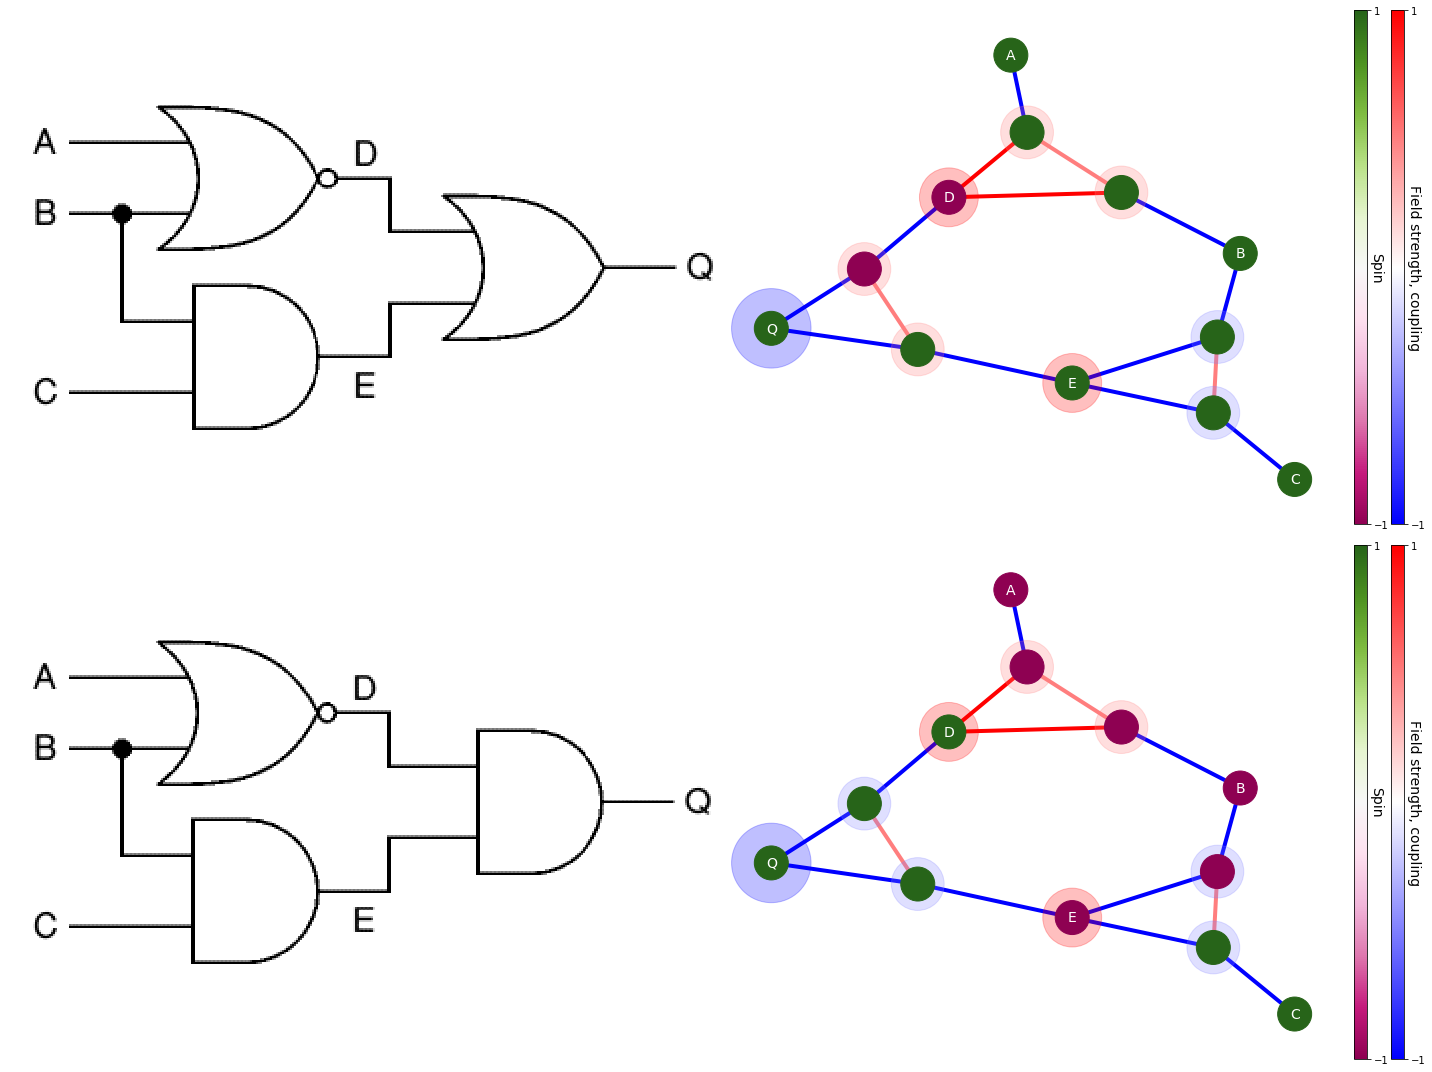

In [47]:
im1 = mpimg.imread('assets/circ1.gif')
im2 = mpimg.imread('assets/circ2.gif')

fig = plt.figure(figsize=(20,15), tight_layout=True)
gs = GridSpec(2, 2)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

ax1.imshow(im1)
ax1.axis("off")
ax3.imshow(im2)
ax3.axis("off")

IsingGraph.visualize_graph(c1.graph, fig=fig, ax=ax2)
IsingGraph.visualize_graph(c2.graph, fig=fig, ax=ax4)

plt.savefig("assets/csat.png", dpi=300, bbox_inches="tight")